# MovieLens 10M Collaborative Genre Tagging
**To do**:
  - try out [this implementation](https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/) of baseline features. 
  - create object classes for models
  - implement TF 2.0 data classes
  - [paperswithcode link](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k)
  - [ML 100k state of the art paper](https://arxiv.org/pdf/1706.02263v2.pdf) (RMSE=0.905): details their evaluation method
  
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/tf-movielens10m.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import glob
import os

%matplotlib inline

In [2]:
path = 'data/ml-10M100K/'  # ML-10M files
train = pd.read_csv(path+'train_predictions.csv')
test = pd.read_csv(path+'holdout_predictions.csv')

In [3]:
train.head()

,movieId,title,Drama,prediction
0,3827,"Slipper and the Rose, The (1976)",0,0
1,5666,"Journey of Natty Gann, The (1985)",0,0
2,1877,"Last Seduction, The (1994)",1,1
3,10407,"Wrong Man, The (1993)",0,1
4,5046,Spacehunter: Adventures in the Forbidden Zone ...,0,0


In [4]:
test.head()

,movieId,title,Drama,prediction
0,5515,Two Much (1995),0,0
1,1208,Treasure Planet (2002),0,0
2,10194,Pure (2002),1,0
3,2085,Dolls (2002),1,1
4,2458,Fort Apache (1948),0,0


## Load rating data

In [5]:
all_files = glob.glob(os.path.join(path, "ratings*.csv"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [6]:
df.head()

,userId,movieId,rating
0,69587,1005,2.0
1,47904,193,4.0
2,26906,3097,3.5
3,31241,559,1.0
4,69402,2541,4.0


In [7]:
df.shape

(10000054, 3)

In [8]:
print('Number of users:', df.userId.nunique())
print('Number of items:', df.movieId.nunique())
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 69878
Number of items: 10677
Min item rating: 0.5
Max item rating: 5.0
Mean item rating: 3.512421932921562


In [19]:
rating_counts = df.groupby('movieId').agg({'rating':'count'}).reset_index()
rating_counts.columns = ['movieId', 'n_ratings']
rating_counts.head()

,movieId,n_ratings
0,0,2412
1,1,14975
2,2,17851
3,3,16075
4,4,18925


In [21]:
rating_avgs = df.groupby('movieId').agg({'rating':'mean'}).reset_index()
rating_avgs.columns = ['movieId', 'mean_rating']
rating_avgs.head()

,movieId,mean_rating
0,0,2.861318
1,1,3.125209
2,2,2.936950
3,3,3.418414
4,4,3.349353


In [23]:
test = pd.merge(test, rating_counts, how='inner', on='movieId')
test = pd.merge(test, rating_avgs, how='inner', on='movieId')
test.head()

,movieId,title,Drama,prediction,n_ratings,mean_rating
0,5515,Two Much (1995),0,0,229,2.814410
1,1208,Treasure Planet (2002),0,0,661,3.303328
2,10194,Pure (2002),1,0,11,3.272727
3,2085,Dolls (2002),1,1,147,3.806122
4,2458,Fort Apache (1948),0,0,84,3.452381


In [25]:
test['correct'] = (test['Drama'] == test['prediction']).astype('int')
test.head()

,movieId,title,Drama,prediction,n_ratings,mean_rating,correct
0,5515,Two Much (1995),0,0,229,2.814410,1
1,1208,Treasure Planet (2002),0,0,661,3.303328,1
2,10194,Pure (2002),1,0,11,3.272727,0
3,2085,Dolls (2002),1,1,147,3.806122,1
4,2458,Fort Apache (1948),0,0,84,3.452381,1


In [70]:
np.arange(0, 101, 5)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

In [83]:
bins = list(np.percentile(test.n_ratings.values, np.arange(0, 101, 10)))
labels = list(np.arange(10, 101, 10))
test['n_ratings_percentile'] = pd.cut(test['n_ratings'], bins=bins, labels=labels, include_lowest=True)
test.head(20)

,movieId,title,Drama,prediction,n_ratings,mean_rating,correct,n_ratings_binned,n_ratings_percentile
0,5515,Two Much (1995),0,0,229,2.814410,1,219.00,70
1,1208,Treasure Planet (2002),0,0,661,3.303328,1,647.00,80
2,10194,Pure (2002),1,0,11,3.272727,0,5.35,10
3,2085,Dolls (2002),1,1,147,3.806122,1,130.00,60
4,2458,Fort Apache (1948),0,0,84,3.452381,1,81.00,50
5,958,Shrek 2 (2004),0,0,6583,3.687984,1,4616.30,100
6,563,Crocodile Dundee (1986),0,0,6718,3.158380,1,4616.30,100
7,5130,Chances Are (1989),0,1,263,3.165399,0,219.00,70
8,7588,World Trade Center (2006),1,0,281,3.033808,0,219.00,70
9,10083,Heaven Help Us (1985),1,1,14,3.321429,1,11.00,20


(0.5, 1.0)

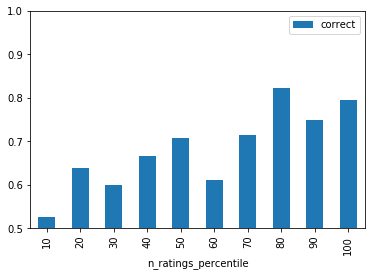

In [88]:
test.groupby('n_ratings_percentile').agg({'correct':'mean'}).plot(kind='bar')
plt.ylim(0.5,1.0)

In [93]:
bins = [1,5,10,20,50,100,200,500,1000,5000,10000]
labels = [5,10,20,50,100,200,500,1000,5000,10000]
test['n_ratings_binned'] = pd.cut(test['n_ratings'], bins=bins, labels=labels, include_lowest=True)
test.head(20)

,movieId,title,Drama,prediction,n_ratings,mean_rating,correct,n_ratings_binned,n_ratings_percentile,mean_rating_binned
0,5515,Two Much (1995),0,0,229,2.814410,1,500,70,3.0
1,1208,Treasure Planet (2002),0,0,661,3.303328,1,1000,80,3.5
2,10194,Pure (2002),1,0,11,3.272727,0,20,10,3.5
3,2085,Dolls (2002),1,1,147,3.806122,1,200,60,4.0
4,2458,Fort Apache (1948),0,0,84,3.452381,1,100,50,3.5
5,958,Shrek 2 (2004),0,0,6583,3.687984,1,10000,100,4.0
6,563,Crocodile Dundee (1986),0,0,6718,3.158380,1,10000,100,3.5
7,5130,Chances Are (1989),0,1,263,3.165399,0,500,70,3.5
8,7588,World Trade Center (2006),1,0,281,3.033808,0,500,70,3.5
9,10083,Heaven Help Us (1985),1,1,14,3.321429,1,20,20,3.5


(0.5, 1.0)

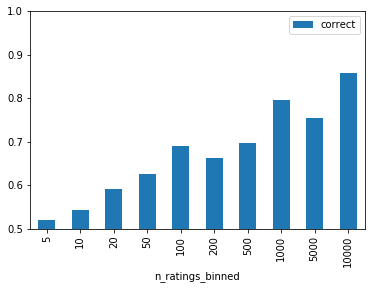

In [95]:
test.groupby('n_ratings_binned').agg({'correct':'mean'}).plot(kind='bar')
plt.ylim(0.5,1.0)

In [90]:
list(np.arange(.5, 5.1, .5))

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [91]:
bins = list(np.arange(.5, 5.1, .5))
labels = list(np.arange(1., 5.1, .5))
test['mean_rating_binned'] = pd.cut(test['mean_rating'], bins=bins, labels=labels, include_lowest=True)
test.head(20)

,movieId,title,Drama,prediction,n_ratings,mean_rating,correct,n_ratings_binned,n_ratings_percentile,mean_rating_binned
0,5515,Two Much (1995),0,0,229,2.814410,1,219.00,70,3.0
1,1208,Treasure Planet (2002),0,0,661,3.303328,1,647.00,80,3.5
2,10194,Pure (2002),1,0,11,3.272727,0,5.35,10,3.5
3,2085,Dolls (2002),1,1,147,3.806122,1,130.00,60,4.0
4,2458,Fort Apache (1948),0,0,84,3.452381,1,81.00,50,3.5
5,958,Shrek 2 (2004),0,0,6583,3.687984,1,4616.30,100,4.0
6,563,Crocodile Dundee (1986),0,0,6718,3.158380,1,4616.30,100,3.5
7,5130,Chances Are (1989),0,1,263,3.165399,0,219.00,70,3.5
8,7588,World Trade Center (2006),1,0,281,3.033808,0,219.00,70,3.5
9,10083,Heaven Help Us (1985),1,1,14,3.321429,1,11.00,20,3.5


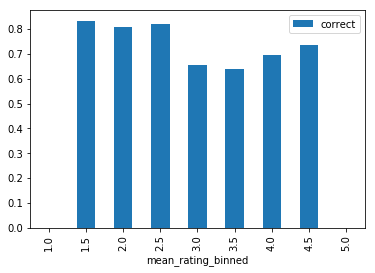

In [92]:
test.groupby('mean_rating_binned').agg({'correct':'mean'}).plot(kind='bar')